# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# Load data

In [2]:
data = pd.read_csv("../../data_anomaly/tsfreshfeatures.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../../data_anomaly/tsfreshfeatures.csv'

In [3]:
data.rename(columns={"Unnamed: 0": "index"}, inplace=True)

In [4]:
for col in ['day','cycle','window']:
    data = data[data.columns.drop(list(data.filter(regex=col)))]

# Data pré-processing

## Removing empty columns

In [5]:
cols = data.isna().mean() != 0

In [6]:
nan_cols = cols[cols == True].index

In [7]:
empty_col = data[nan_cols].isna().mean() == 1

In [8]:
data.drop(columns=empty_col[empty_col == True].index.tolist(), inplace=True)

## Removing constant columns

In [9]:
data = data.loc[:, (data != data.iloc[0]).any()]

## Remove last nans

In [10]:
test = data.replace([np.inf, -np.inf], np.nan)
data = test.dropna(axis=1)

## Create new col

In [11]:
data["day_cycle_window_temp"] = data["index"].str.split("_")

/tmp/ipykernel_18719/2530755452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day_cycle_window_temp"] = data["index"].str.split("_")


In [13]:
data["day"] = data["day_cycle_window_temp"].apply(lambda x: int(x[0]))
data["cycle"] =  data["day_cycle_window_temp"].apply(lambda x: int(x[1]))
data["window"] =  data["day_cycle_window_temp"].apply(lambda x: int(x[2]))
data.drop(columns={'day_cycle_window_temp'},inplace=True)

/tmp/ipykernel_18719/3981017085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day"] = data["day_cycle_window_temp"].apply(lambda x: int(x[0]))
/tmp/ipykernel_18719/3981017085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cycle"] =  data["day_cycle_window_temp"].apply(lambda x: int(x[1]))
/tmp/ipykernel_18719/3981017085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

# Détection d'anomalies

## Focus sur les windows 1

In [47]:
data.cycle.unique()

array([1, 2, 3, 4, 5])

In [48]:
data_window_1=data[data.cycle==2]

In [49]:
iforest = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.05,
    max_features=4,
    bootstrap=False,
    n_jobs=-1,
    random_state=1,
)

In [50]:
pred = iforest.fit_predict(data_window_1)
data_window_1["scores"] = iforest.decision_function(data_window_1)
data_window_1["anomaly_label"] = pred

/home/rico/miniconda3/envs/AML/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/tmp/ipykernel_18719/183073226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_window_1["scores"] = iforest.decision_function(data_window_1)
/tmp/ipykernel_18719/183073226.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_window_1["anomaly_label"] = pred


In [51]:
data_window_1[data_window_1.anomaly_label == -1]

,index,p1__variance_larger_than_standard_deviation,p1__has_duplicate_max,p1__has_duplicate_min,p1__has_duplicate,p1__sum_values,p1__abs_energy,p1__mean_abs_change,p1__mean_change,p1__median,...,p11__lempel_ziv_complexity__bins_2,p11__lempel_ziv_complexity__bins_3,p11__lempel_ziv_complexity__bins_5,p11__lempel_ziv_complexity__bins_10,p11__lempel_ziv_complexity__bins_100,day,cycle,window,scores,anomaly_label
68,1_2_1,0.0,1.0,0.0,1.0,151.920542,242.774369,0.026113,-0.002919,1.603161,...,0.130000,0.190000,0.250000,0.350000,0.580000,1,2,1,-0.154359,-1
151,1_2_174,0.0,0.0,1.0,1.0,-71.640309,53.250047,0.009834,-0.003031,-0.726345,...,0.190000,0.250000,0.310000,0.390000,0.500000,1,2,174,-0.018933,-1
159,1_2_181,0.0,1.0,1.0,1.0,-3.617493,4.362085,0.000000,0.000000,-1.205831,...,0.666667,0.666667,0.666667,0.666667,0.666667,1,2,181,-0.037462,-1
161,1_2_2,0.0,0.0,1.0,1.0,-49.564893,47.781749,0.022576,-0.019525,-0.698755,...,0.140000,0.170000,0.240000,0.340000,0.560000,1,2,2,-0.080893,-1
216,1_2_7,0.0,0.0,1.0,1.0,-102.285398,111.256098,0.013265,-0.000658,-1.025447,...,0.160000,0.220000,0.290000,0.380000,0.520000,1,2,7,-0.051179,-1
599,2_2_57,0.0,0.0,1.0,1.0,-215.819845,469.861758,0.019761,0.004211,-2.211907,...,0.150000,0.210000,0.280000,0.380000,0.560000,2,2,57,-0.014936,-1
606,2_2_63,0.0,0.0,0.0,1.0,-98.561272,116.002052,0.057101,-0.005688,-0.963905,...,0.140000,0.200000,0.310000,0.410000,0.640000,2,2,63,-0.100464,-1
607,2_2_64,0.0,1.0,1.0,1.0,-99.734516,113.605343,0.031045,0.011781,-0.931604,...,0.160000,0.210000,0.290000,0.390000,0.610000,2,2,64,-0.098636,-1
619,2_2_75,0.0,0.0,1.0,1.0,-23.496861,24.799522,0.027966,0.009139,-0.216846,...,0.150000,0.190000,0.240000,0.270000,0.490000,2,2,75,-0.085041,-1
987,3_2_44,0.0,1.0,0.0,1.0,-23.823588,78.025738,0.076153,0.016927,-0.284539,...,0.140000,0.200000,0.280000,0.370000,0.580000,3,2,44,-0.073276,-1


In [52]:
data_window_1["anomaly"] = data_window_1["anomaly_label"].apply(
    lambda x: "outlier" if x == -1 else "inlier"
)

/tmp/ipykernel_18719/598380592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_window_1["anomaly"] = data_window_1["anomaly_label"].apply(


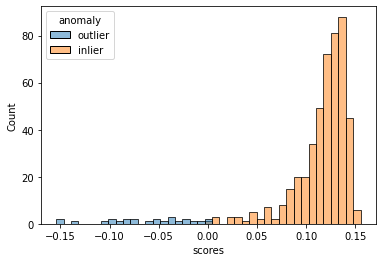

In [53]:
fig = sns.histplot(data=data_window_1, x="scores", hue="anomaly")
plt.show()

Having said that, If you are very confident about the results of Isolation Forest classifier and you have a capacity to train another model then you could use the output of Isolation Forest i.e -1/1 values as target-class to train a Random Forest classifier. This will give you feature importance for detecting anomaly.

In [17]:
data.to_csv("../data/tsfresh_data_cleaned.csv")